In [1]:
import numpy as np
import matplotlib.pyplot as plt

Reading run 1
Reading run 2
Reading run 3
Reading run 4
Reading run 5
Reading run 6
Reading run 7


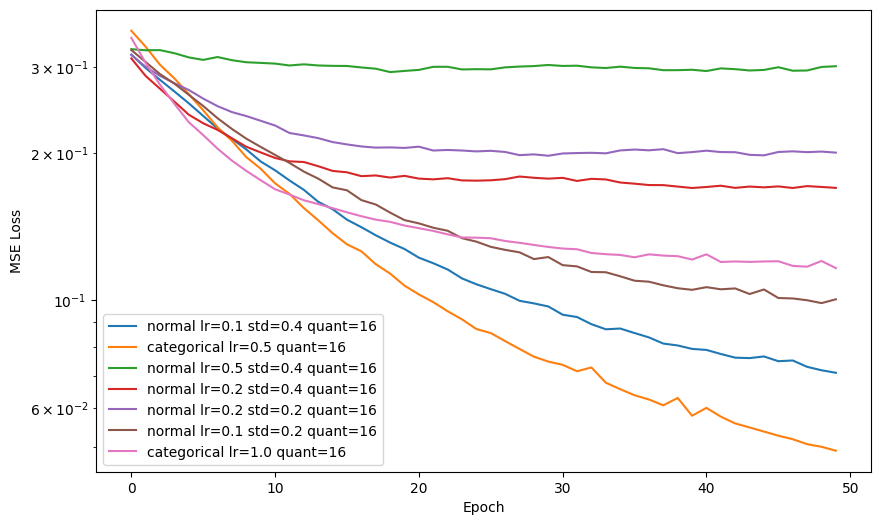

In [ ]:
def read_file (filename : str, mode : int= 0):
    # We know the the return is structured as
    # {epoch      : np.array,
    #  train_loss : np.array,
    #  val_loss   : np.array,
    #  train_acc  : np.array,
    #  val_acc    : np.array,
    #  dist       : str,
    #  lr         : float,
    #  std        : float,
    #  quant      : int,
    #  Height     : int,
    #  Width      : int,
    #  Epochs     : int,
    #  samples_per_image : int
    # }

    '''
     File structure:
    
    Dataset parameters:
        Data Padding Amount: <int>
        Sub Shader Threshold: <float>
        Training Dataset:
            Training Size: <int>
            Training Batch Size: <int>
        Validation Dataset:
            Validation Size: <int>
            Validation Batch Size: <int>
        Test Dataset:
            Test Size: <int>
            Test Batch Size: <int>
    Model Parameters:
        Model Height: <int>
        Model Width: <int>
        Model Distribution: <str>
            Standard Deviation: <float> (If normal)
        Upscale Factor: <int>
        Number of Levels: <int>
    Training Parameters:
        Learning Rate: <float>
        Optimizer: <str>
        Samples per Image: <int>
        Epochs: <int>
        Sample Update Rate: <int>
        Sample Update Amount: <int>
    ----------------------------------------
    <Dataset Type>
    Epoch <int>
    Time: <hr:min:sec>
    Epoch: <int>
    Compute Time (s): <int>
    Samples Total: <int>
    Samples Correct: <int>
    Accuracy: <float>
    Entropy: <float>
    Loss: <float>
    ----------------------------------------
    ...
    '''
    data = {}

    with open (filename, 'r') as f:
        # Skip to Model Parameters
        for _ in range (13):
            f.readline ()

        # Extract info
        Height = int (f.readline ().split (':')[1].strip ())
        Width  = int (f.readline ().split (':')[1].strip ())
        Dist   = f.readline ().split (':')[1].strip ()

        if Dist == 'normal':
            Std = float (f.readline ().split (':')[1].strip ())
        else:
            Std = 0.0

        # Skip Upscale Factor
        f.readline ()

        Quant = int (f.readline ().split (':')[1].strip ())

        # Skip to Training Parameters
        f.readline ()

        Lr = float (f.readline ().split (':')[1].strip ())
        f.readline ()  # Optimizer
        SamplesPerImage = int (f.readline ().split (':')[1].strip ())
        Epochs = int (f.readline ().split (':')[1].strip ())

        # Skip SUR and SUA
        for _ in range (2):
            f.readline ()

        # Prepare data arrays
        data['Height'] = Height
        data['Width']  = Width
        data['dist']   = Dist
        data['std']    = Std
        data['quant']  = Quant
        data['lr']     = Lr
        data['epochs'] = Epochs
        data['samples_per_image'] = SamplesPerImage
        data['epoch'] = np.arange(0, Epochs)
        data['train_loss'] = np.zeros(Epochs)
        data['val_loss'] = np.zeros(Epochs)
        data['train_acc'] = np.zeros(Epochs)
        data['val_acc'] = np.zeros(Epochs)

        try:
            while True:
                # Skip separator
                f.readline ()

                # Read dataset type
                dataset_type = f.readline ().strip ()

                # Skip Epoch
                f.readline ()

                # Skip Time
                f.readline ()

                # Skip Epoch (redundant)
                epoch = int (f.readline ().split (':')[1].strip ())
                if epoch >= Epochs:
                    break

                # Skip compute time
                f.readline ()

                # Skip samples total and correct
                for _ in range (2):
                    f.readline ()

                acc = float (f.readline ().split (':')[1].strip ())
                entropy = float (f.readline ().split (':')[1].strip ())
                loss = float (f.readline ().split (':')[1].strip ())

                if dataset_type == 'Training Inference':
                    # For simplicity, we use same data for train and val
                    data['train_acc'][epoch] = acc
                    data['train_loss'][epoch] = loss
                elif dataset_type == 'Validation':
                    data['val_acc'][epoch] = acc
                    data['val_loss'][epoch] = loss

                # Skip separator
                f.readline ()
        except:
            pass

    # Invert loss data
    data['train_loss'] = -data['train_loss']
    data['val_loss']   = -data['val_loss']

    return data

base_folder = './2025_11_25c/'
runs = []
for i in range(1, 8):
    print(f'Reading run {i}')
    data = read_file (base_folder + f'{i:03d}/a/mean_reward.txt')
    runs.append(data)

# For each run, plot the validation loss over epochs.
# Label each plot with their <dist> <lr> <std> <quant>
# If the std is 0.0, skip it in the label.

plt.figure(figsize=(10, 6))
for run in runs:
    label = f"{run['dist']} lr={run['lr']}"
    if run['std'] != 0.0:
        label += f" std={run['std']}"
    label += f" quant={run['quant']}"
    plt.plot(run['epoch'], run['val_loss'], label=label)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()




Reading run 1 for quant=16
Reading run 2 for quant=16
Reading run 3 for quant=16
Reading run 4 for quant=16


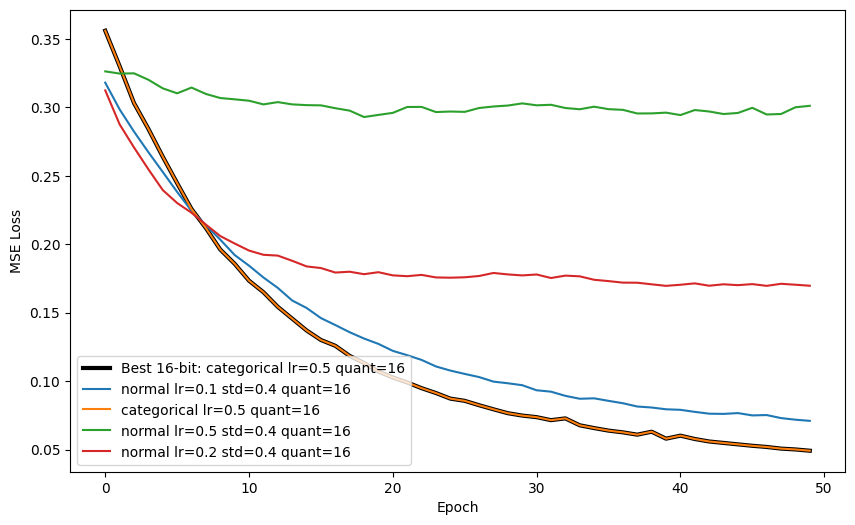

In [16]:
# Extract the best loss and store as best_16
best_16 = None
best_loss = float('inf')
for run in runs:
    if run['quant'] == 16:
        min_loss = np.min(run['val_loss'])
        if min_loss < best_loss:
            best_loss = min_loss
            best_16 = run

runs_4 = []
for i in range(1, 5):
    data = read_file (base_folder + f'{i:03d}/a/mean_reward.txt')
    print(f'Reading run {i} for quant={data["quant"]}')
    runs_4.append(data)

# Plot best_16 against each of the runs_4
plt.figure(figsize=(10, 6))
# Plot best_16
label = f"Best 16-bit: {best_16['dist']} lr={best_16['lr']}"
if best_16['std'] != 0.0:   
    label += f" std={best_16['std']}"
label += f" quant={best_16['quant']}"
plt.plot(best_16['epoch'], best_16['val_loss'], label=label, linewidth=3, color='black')
for run in runs_4:
    label = f"{run['dist']} lr={run['lr']}"
    if run['std'] != 0.0:
        label += f" std={run['std']}"
    label += f" quant={run['quant']}"
    plt.plot(run['epoch'], run['val_loss'], label=label)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()
